<a href="https://colab.research.google.com/github/AdrianT18/Sensor-Fusion/blob/master/BayesianNetwork%20and%20EKF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python-headless tensorflow-probability pymc3 theano


In [ ]:
!git clone https://github.com/WongKinYiu/yolov7.git


In [ ]:
!wget -O yolov7.pt 'https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt'


In [ ]:
import sys
sys.path.append('/content/yolov7')


In [ ]:
from yolov7.models.experimental import attempt_load
from yolov7.detect import detect
from yolov7.utils.plots import plot_one_box
from yolov7.models.experimental import attempt_load

In [ ]:
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'


In [ ]:
import numpy as np
import tensorflow_probability as tfp
from tqdm import tqdm
tfd = tfp.distributions
import cv2
import argparse
import torch

In [ ]:
import pymc as pm

# KITTI Dataset Preprocessing Script Overview

This script is specifically designed for preprocessing data from the KITTI dataset. Its primary function is to synchronise and refine the data pairs comprising LiDAR and camera inputs. The process involves several key steps, outlined below:

## Data Synchronization
- **Objective**: Pair LiDAR and camera data based of sequence.
- **Process**: The script reads data from the dataset and synchronises it into LiDAR-Camera pairs.

## Data Refinement
- **Step 1**: Remove points outside the camera's field of view to ensure relevance to the camera perspective.
- **Step 2**: Apply calibration to these paired data points.

## Apply Calibration function
This functions has multiple steps as described below:

### Lidar to Camera Transformation
![000000 Bay.png](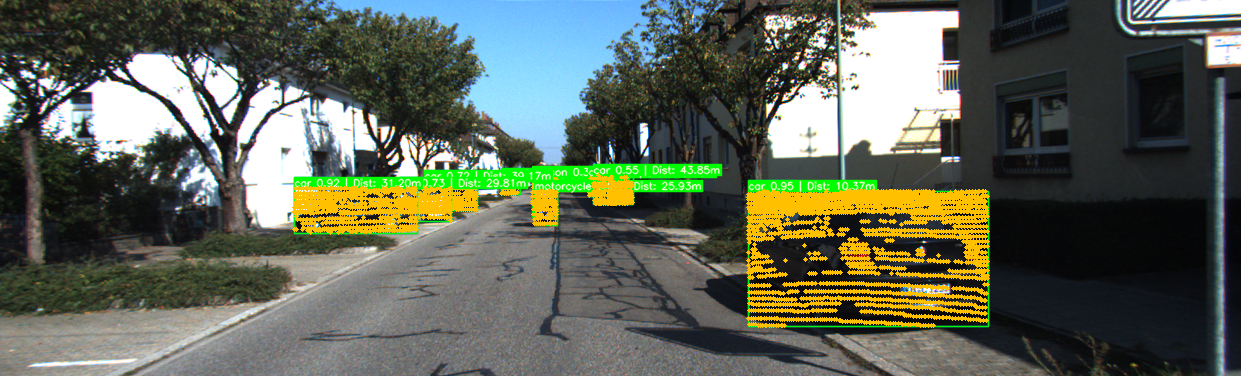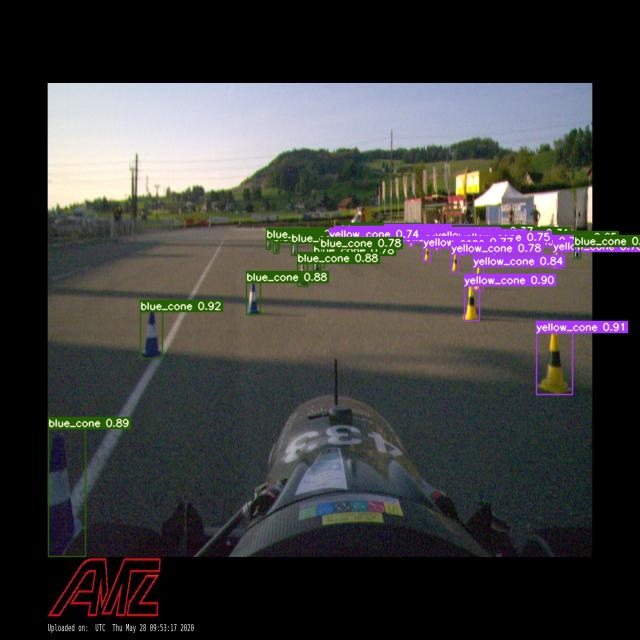)- **Inputs**: LiDAR points, `tr_velo_cam` (LiDAR to camera coordinate transformation matrix), and `Pcam` (camera projection matrix).
- **Process**: `tr_velo_cam` matrix allows us to rotate any 3D LiDAR points to the camera pixel space using the homogeneous representation. In order to convert a transformation matrix to homogeneous representation we have to add a row of new coordinated on the bottom where 0's will be placed under the rotation portion and a 1 will be placed under the translation portion like so:

$$
    T = \begin{bmatrix}
            r_{11} & r_{12} & r_{13} & t_{14} \\
            r_{21} & r_{22} & r_{23} & t_{24} \\
            r_{31} & r_{32} & r_{33} & t_{34} \\
                 0 &      0 &      0 & 1      \\
        \end{bmatrix}
$$

### Projection of LiDAR Points onto Camera Image
- **Process**: The transformed LiDAR points are multiplied with the reshaped `P_cam` matrix to project them onto the camera image. Points with negative z-coordinates (not in front of the camera) are filtered out. These points are then normalized to convert to 2D image coordinates, which are paired with corresponding LiDAR points.

## Removing Points Function
An additional parameter `min_intensity`, is used as a threshold to filter points based on intensity.

### Steps in the Removal Process
1. **Apply Calibration**: Project LiDAR points onto the camera image using the transformation and projection matrices.
2. **Initial Filtering**: Utilise the 'valid_projection_mask' to retain only points with valid projections (based on intensity) onto the camera image plane.
3. **Further Filtering**: Create a new mask to check if the projected 2D points are within the camera's boundaries and if the LiDAR points' intensity exceeds the minimum threshold.
4. **Final Stage**: Apply the newly created mask to remove points that are either not visible in the camera image or do not meet the intensity criteria.


In [ ]:
import os
import cv2
import numpy as np


# Loading camera data
def load_camera_image(file_path):
    image = cv2.imread(file_path)
    return image


# Loading lidar data
def load_lidar_data(file_path):
    lidar_data = np.fromfile(file_path, dtype=np.float32).reshape(-1, 4)
    return lidar_data


# Here we read the calibration file and return the transformation matrix from the LiDAR to the camera and the camera matrix.
# This will be used to project the LiDAR points into the camera image. As both sensors will be calibrated using this file.
def read_kitti_calibration(calib_file_path):
    calib_params = {}

    # Here we read the calib file and then store the values in a dictionary.
    with open(calib_file_path, 'r') as file:
        for line in file:
            if ':' in line and line.split(':')[1].strip():
                try:
                    key, value = line.split(': ')
                    calib_params[key] = np.array([float(x) for x in value.split()])
                except ValueError:
                    continue

    # Here we get the transformation matrix from the LiDAR to the camera and the camera matrix.
    # P2 and Tr are the camera matrix taken from the left camera and the transformation matrix from the LiDAR to the camera.
    P_cam = calib_params.get('P2', np.eye(3, 4))
    T_velo_cam = np.vstack((calib_params.get('Tr', np.eye(4)[:3, :]).reshape(3, 4), [0, 0, 0, 1]))

    return T_velo_cam, P_cam


# This function aligns LiDAR data with the camera's perspective.
# 3 main steps:
# 1. Transforming LiDAR points to camera coordinates which ensures that a 4xN format is made after transformation.
# 2. Then we project these points onto the camera's image plane, converting 3D points to a 2D visual representation.
# 3. Filtering out points outside the camera's field of view to enhance system efficiency and accuracy.
# The result is a combination of 2D and 3D points, providing a comprehensive view from the camera's perspective.

def apply_calibration(lidar_points, Tr_velo_cam, P_cam):
    # Reshape the camera matrix for compatibility with LiDAR data (3X4)
    P_cam = P_cam.reshape(3, 4)

    # Create a homogeneous representation of LiDAR points
    num_points = lidar_points.shape[0]
    lidar_homogeneous = np.hstack((lidar_points[:, :3], np.ones((num_points, 1))))

    # Transform LiDAR points to camera coordinates
    lidar_cam = np.dot(Tr_velo_cam, lidar_homogeneous.T)
    if lidar_cam.shape[0] != 4:
        raise ValueError("Transformed LiDAR points (lidar_cam) should be a 4xN matrix.")

    # Project LiDAR points onto the image plane
    lidar_img = np.dot(P_cam, lidar_cam)

    # Filter points not in the camera's field of view
    in_front_of_camera = lidar_cam[2, :] > 0
    lidar_img = lidar_img[:, in_front_of_camera]
    lidar_cam = lidar_cam[:, in_front_of_camera]

    # Convert to 2D image coordinates
    lidar_img_2d = lidar_img[:2, :] / lidar_img[2, :]

    # Combine 2D image coordinates with LiDAR points
    combined_data = np.zeros((lidar_img_2d.shape[1], 4))
    combined_data[:, :2] = lidar_img_2d.T
    combined_data[:, 2:4] = lidar_cam[:2, :].T

    return combined_data, in_front_of_camera


# This function synchronises data between camera and LiDAR directories based on timestamps. E.G, 000000.png and 000000.bin
# 3 main steps:
# 1. Reads all camera image and LiDAR data files, ensuring they are in sorted order.
# 2. Loads timestamps from a specified file.
# 3. Creates pairs of corresponding camera and LiDAR files aligned with each timestamp.
# The result is a list of tuples, each containing synchronized paths -> (camera_path, lidar_path, timestamp).

def synchronize_data(camera_dir, lidar_dir, timestamp_file):
    # A list to hold synchronized pairs
    synchronized_pairs = []

    # List and sort camera and LiDAR files
    camera_files = sorted([f for f in os.listdir(camera_dir) if f.endswith('.png')])
    lidar_files = sorted([f for f in os.listdir(lidar_dir) if f.endswith('.bin')])

    # Read timestamps from the file - crucial for synchronization
    with open(timestamp_file, 'r') as f:
        timestamps = f.readlines()

    # Zip together ->  (camera_path, lidar_path, timestamp).
    for camera_file, lidar_file, timestamp in zip(camera_files, lidar_files, timestamps):
        camera_path = os.path.join(camera_dir, camera_file)
        lidar_path = os.path.join(lidar_dir, lidar_file)
        synchronized_pairs.append((camera_path, lidar_path, timestamp.strip()))

    return synchronized_pairs


# This function removes LiDAR points based on their projection onto the camera image and intensity.
# 3 main steps:
# 1. Apply calibration to project LiDAR points onto the camera image plane using the provided matrices.
# 2. Filter out LiDAR points that do not project intensely onto the camera image.
# 3. Create a mask to select points within the image boundaries and above the minimum intensity threshold.
# The result is a filtered set of LiDAR points that are visible in the camera image and meet intensity criteria.

def remove_points(lidar_points, camera_image, Tr_velo_cam2, P_rect2_cam2, min_intensity):
    # Project LiDAR points onto the camera image plane and filter valid projections
    projected_points, valid_projection_mask = apply_calibration(lidar_points, Tr_velo_cam2, P_rect2_cam2)
    lidar_points = lidar_points[valid_projection_mask]

    # Create a mask for points within image boundaries and above the intensity threshold
    # I choose to use the minimum intensity threshold of 0 to include all points. But can be changed in order
    # to filter out more points.
    mask = (projected_points[:, 0] >= 0) & (projected_points[:, 0] < camera_image.shape[1]) & \
           (projected_points[:, 1] >= 0) & (projected_points[:, 1] < camera_image.shape[0]) & \
           (lidar_points[:, 3] >= min_intensity)

    return lidar_points[mask]



In [ ]:
import logging
logging.basicConfig(level=logging.ERROR)


# YOLOV7 usage for object detection in KITTI dataset

## Object detection function
- **Inputs**: camera image, lidar points, output directory and filename.

Originally yolov7 is used in the command line and you call it to do training, testing and detection. The original way to detect objects would be like this where I used it to detect cones.

```
!python detect.py --weights runs/train/exp/weights/best.pt --conf 0.1 --source cones/test/images
```

As a result I had to modify the detect script in order to be able to call it as function. Here is what was changed:

### Function signiture
- **Original code**:Detect function only takes save_img as a parameter.
- **Modified code**:Now it takes in an additional parameter `opt` which allows the function to be called with different options dynamically.

### Function return
- **Original code**: Does not return anything.
- **Modified code**: It now returns `detected_objects` at the end. This means that now it will process the detection but also return it.

### Detected object handling
- **Original code**: n/a
- **Modified code**: I have added a new datastructure in the code where a new list `detected_objects` is initialised at the start of the function. For each new detection it appends a dictionary containing bounding box coordinates and labels.

In [ ]:
# Save the processed data to the output directory.
def save_processed_data(camera_image, lidar_points, output_dir, filename):
    cv2.imwrite(os.path.join(output_dir, f"{filename}.png"), camera_image)
    lidar_points.tofile(os.path.join(output_dir, f"{filename}.bin"))


# This is a wrapper function for the detect function in detect.py
def detect_wrapper(opt):
    import yolov7.detect
    yolov7.detect.detect(opt)


# Performs object detection on an image and saves the results.
def object_detection_function(camera_image_with_lidar_overlay, model, output_dir):
    # Temp file of detected objects
    temp_image_path = os.path.join(output_dir, 'temp_detection_image.png')
    cv2.imwrite(temp_image_path, camera_image_with_lidar_overlay)

    # Options for yolov7 detection
    opt = argparse.Namespace()
    opt.source = temp_image_path
    opt.weights = 'yolov7.pt'
    opt.img_size = 640
    opt.conf_thres = 0.25
    opt.iou_thres = 0.45
    opt.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    opt.view_img = False
    opt.save_txt = False
    opt.nosave = False
    opt.classes = None
    opt.agnostic_nms = False
    opt.augment = False
    opt.project = output_dir
    opt.name = 'detections'
    opt.exist_ok = True
    opt.save_img = True
    opt.no_trace = True

    # Perform detection
    detected_objects = detect(opt)

    # Read the image with objects detected
    detections_image = cv2.imread(os.path.join(output_dir, 'detections', os.path.basename(temp_image_path)))
    print("Detected objects format at the end of detect function:", type(detected_objects), "Sample:",
          detected_objects[:1])

    return detections_image, detected_objects

In [ ]:
import numpy as np

"""
This script is the implementation of the Extended Kalman Filter.
In short the EKF is a non-linear version of the Kalman Filter. Which is used to estimate the state of a system.
By updating the state with the measurement and the prediction.
In this case I have used the Bicycle Model to track and predict the state.
"""


class ExtendedKalmanFilter:
    # The initial state is the state of the system at the start.
    def __init__(self, initial_state, state_covariance, process_noise, measurement_noise, wheelbase):
        self.state = initial_state
        self.covariance = state_covariance
        self.process_noise = process_noise
        self.measurement_noise = measurement_noise
        self.wheelbase = wheelbase

    # Here we predict the next state based on control inputs and the time step.
    def predict(self, control_input, dt):
        # Extract steering angle and velocity from control input
        steering_angle, velocity = control_input

        # Current state variables
        x, y, psi, v = self.state

        # Predict new state using the motion model
        x_new = x + velocity * np.cos(psi) * dt
        y_new = y + velocity * np.sin(psi) * dt
        psi_new = psi + (velocity / self.wheelbase) * np.tan(steering_angle) * dt
        v_new = velocity

        # Update state
        self.state = np.array([x_new, y_new, psi_new, v_new])

        # Update covariance matrix which represents the uncertainty of the state
        F = self.jacobian_of_process_model(steering_angle, velocity, psi, dt)
        self.covariance = F @ self.covariance @ F.T + self.process_noise

    # Here we update the state estimator with a new measurement.
    def update(self, measurement):

        # Calculate Kalman gain
        H = self.jacobian_of_measurement_model()
        S = H @ self.covariance @ H.T + self.measurement_noise
        K = self.covariance @ H.T @ np.linalg.inv(S)

        # Update state
        y = measurement - self.measurement_model()
        self.state += K @ y

        # Update covariance matrix
        I = np.eye(self.covariance.shape[0])
        self.covariance = (I - K @ H) @ self.covariance

    # Here we process the model using the Bicycle Model. - TODO if you have control input
    def process_model(self, state, control_input, dt):
        pass

    # Return the position and velocity of the system.
    def measurement_model(self):
        return self.state[:2]

    # Here we calculate the Jacobian of the process model.
    def jacobian_of_process_model(self, steering_angle, velocity, psi, dt):
        # Compute partial derivatives for the Jacobian matrix
        a11 = 1
        a12 = 0
        a13 = -velocity * np.sin(psi) * dt
        a14 = np.cos(psi) * dt
        a21 = 0
        a22 = 1
        a23 = velocity * np.cos(psi) * dt
        a24 = np.sin(psi) * dt
        a31 = 0
        a32 = 0
        a33 = 1
        a34 = (1 / self.wheelbase) * np.tan(steering_angle) * dt
        a41 = 0
        a42 = 0
        a43 = 0
        a44 = 1

        J = np.array([[a11, a12, a13, a14],
                      [a21, a22, a23, a24],
                      [a31, a32, a33, a34],
                      [a41, a42, a43, a44]])
        return J

    # Computes the Jacobian matrix of the measurement model.
    def jacobian_of_measurement_model(self):
        H = np.array([[1, 0, 0, 0],
                      [0, 1, 0, 0]])
        return H


In [ ]:
def calculate_distance_to_object(lidar_data, projected_points, bbox):
    # Bounding box coordinates
    x1, y1, x2, y2 = bbox

    # We find the LiDAR points that fall within the bbox
    associated_points_indices = [i for i, p in enumerate(projected_points) if x1 <= p[0] <= x2 and y1 <= p[1] <= y2]

    # Calculate the average distance of the associated LiDAR points
    if associated_points_indices:
        associated_lidar_points = [lidar_data[i] for i in associated_points_indices]
        distances = [np.sqrt(p[0] ** 2 + p[1] ** 2 + p[2] ** 2) for p in associated_lidar_points]
        return np.mean(distances)
    return None


# This function stores the estimated position to a text file. Used to compare to ground truth data
def store_estimated_position(timestamp, estimated_position, output_dir):
    with open(os.path.join(output_dir, 'ekf_estimated_positions.txt'), 'a') as f:
        f.write(f"{timestamp} {estimated_position[0]} {estimated_position[1]}\n")


# This function runs the sensor fusion process on a set of data. It synchronizes the camera with LiDAR data,
# applies EKF for state estimation, performs object detection and saves the results.
# Future me - remove max frames for full dataset - TODO
def run_sensor_fusion(image_dir, lidar_dir, calib_file_path, output_dir, timestamp_file, batch_size=10,
                      max_frames=1000):
    # Initialization and setup of EKF
    temp_image_path = os.path.join(output_dir, 'temp_detection_image.png')
    timestamps = np.loadtxt(timestamp_file)

    T_velo_cam, P_cam = read_kitti_calibration(calib_file_path)
    WHEELBASE = 2.8  # meters

    initial_state = np.array([0.0, 0.0, 0.0, 0.0])
    state_covariance = np.diag([1, 1, 0.1, 1])
    process_noise = np.eye(4) * 0.1
    measurement_noise = np.eye(2) * 1

    # Make an instance of EKF with initial parameters ^^^
    ekf = ExtendedKalmanFilter(
        initial_state,
        state_covariance,
        process_noise,
        measurement_noise,
        WHEELBASE
    )

    # Load & synchronize data pairs.
    # TODO - remove max frames for full dataset (Second line)
    data_pairs = synchronize_data(image_dir, lidar_dir, timestamp_file)
    data_pairs = data_pairs[:max_frames]
    total_pairs = len(data_pairs)

    prev_position = None
    prev_timestamp = None

    # Load YOLOv7 model
    object_detection_model = attempt_load('yolov7.pt', map_location='cuda')

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # loop through data pairs
    ekf_estimations = []
    for idx, (image_path, lidar_path, timestamp) in enumerate(tqdm(data_pairs, desc='Processing frames', unit='frame')):
        # Load and preprocess data
        camera_image = load_camera_image(image_path)
        lidar_points = load_lidar_data(lidar_path)
        lidar_points = remove_points(lidar_points, camera_image, T_velo_cam, P_cam, min_intensity=0.1)

        projected_points, _ = apply_calibration(lidar_points, T_velo_cam, P_cam)
        camera_image_with_lidar_overlay = camera_image.copy()
        # TODO - add this back in if you want to see the projected points
        # visualize_lidar_camera_projection(camera_image_with_lidar_overlay, lidar_points, projected_points)

        # Calculate velocity and predict state using EKF
        timestamp = float(timestamp)
        if prev_position is not None and prev_timestamp is not None:
            dt = timestamp - prev_timestamp
            if dt > 0:
                displacement = np.linalg.norm(ekf.state[:2] - prev_position)
                velocity = displacement / dt
            else:
                velocity = 0
        else:
            velocity = 0
            dt = 0.1
        # Predict EKF state
        prev_position = ekf.state[:2].copy()
        prev_timestamp = timestamp
        ekf.predict([0.0, velocity], dt)

        # Update EKF with new LiDAR data points
        for point in lidar_points:
            ekf.update(point[:2])
        # Save EKF estimation
        estimated_position = ekf.state[:2]
        store_estimated_position(
            timestamp,
            estimated_position,
            output_dir
        )
        # Object detection and annotation with distance information
        camera_image_with_detections, detected_objects = object_detection_function(
            camera_image_with_lidar_overlay,
            model,
            output_dir
        )

        for detected_object in detected_objects:
            bbox = detected_object['bbox']
            label = detected_object['label']

            distance = calculate_distance_to_object(lidar_points, projected_points, bbox)

            if distance is not None:
                label_with_distance = f'{label} | Dist: {distance:.2f}m'
                plot_one_box(
                    bbox,
                    camera_image_with_detections,
                    label=label_with_distance,
                    color=(0, 255, 0),
                    line_thickness=1
                )

        # Save processed data
        base_filename = os.path.splitext(os.path.basename(image_path))[0]
        save_processed_data(camera_image_with_detections, lidar_points, output_dir, base_filename)

    print(f"All data saved to {output_dir}.")


if __name__ == "__main__":
    # Use CPU if GPU is not available!!
    model = attempt_load('/content/yolov7.pt', map_location='cuda')
    image_dir = '/content/drive/MyDrive/Google Colab/image_2_1'
    lidar_dir = '/content/drive/MyDrive/Google Colab/velodyne_1'
    timestamp_file = '/content/drive/MyDrive/Google Colab/timestamp/times.txt'
    calib_file_path = '/content/drive/MyDrive/Google Colab/calib/calib.txt'
    output_dir = '/content/drive/MyDrive/Google Colab/EKF2'

    # TODO - remove max frames for full dataset
    run_sensor_fusion(image_dir, lidar_dir, calib_file_path, output_dir, timestamp_file, batch_size=10, max_frames=1000)


# Bayesian network used to fuse LiDAR and Stereo camera
This script is using PYMC4 library to make a Bayesian network model which is focusing on detected object distance. I will explain the functions which are straight-forward to understand.

# Filter lidar points
- **Inputs**: lidar points, bbox, t_velo_Cam and P_cam

This function goal is to remove any points that are not in the detected objects bounding box. The `visualize_lidar_points_on_image` function visualises this to prove that actually happens.

# Calcualte distance to detected object

- **Inputs**: filterd lidar points and bbox

### Step 1
The function starts by extracting the bbox coordinates from the bbox parameter.

### Calculating distances
Each point from `filter_lidar_points` is then calculated using Euclidean distance from the sensor. This is done using the `np.linalg.norm(point[:3])` which computes the vector representing the lidar point. 3 takes the `x,y,z` coordinates off the points and ignores intensity.

For reference:

x -> Forward

y -> left

z -> up

Then if there are more then 3 points the function will calculate the median of these distances. The reason for using median instead of the mean is because its less affected by outliers.

Returns the calculated distance or None if there are no points or any errors.

# Bayesian Network
- **Inputs**: lidar data, bbox, T_velo_cam and P_Cam

The goal of this function is to estimate the distance to a detected object using Lidar data and Bayesian statistical modeling.

### Creating the Bayesian model
Here I use the `pm.Model()' from PYMC library to define a probabilistic model.

Inside the model a prior distribution for the objects distance is defined using `pm.Normal`. This represents the initial belief about the distance before observing the LiDAR points. 15 mean and 30 std indicate a wide range of possible distances since there are close and far objects.

We then filter out the lidar points using the `filter_lidar_points` function. Then we use `bay_calculate_distance_to_object` to compute the avg distance to the object using LiDAR points.

#### Defining Likelihood and Performing sampling
If an observed distance is available the function defines a likelihood distribution for it. Which is then modeled as a normal distribution centered around the `distance_mean` with a std of 5.

Then Bayesian inference is performed using Markov Chain Monte Carlo sampling. This process samples from the posterior distribution of the `distance_mean`, given the observed distance.

#### Final step
If the sampling was succesful the function calculates the mean of the sampled `distance_mean` values from the posterior dis. This mean is the Bayesian estimate of the distance to the obkect. Finally the function returns the estimated distance or `None` if it cannot be estimated.

# Improvment - Before and after vectorization

# Before vectorization
Before optimising the code by vecorizing it, I was running for loops which turned out to be very slow. It took about 1min 20 seconds to process 1 set of LiDAR points and Stereo camera. Essentially if I was to run a full scenario which contained 4000 frames it would take a very long time.

# After vectorization
After discovering vectorization which is used with NumPY. Instead of processing each element one by one such as lidar points, instead we apply the operation to the entire array in a single step which makes the process much faster. For instance instead of 1min 20 seconds it took about 8 seconds. In addition to this I have also added batch I/O saving so instead of saving 1 frame after it has been  processed it now is saved after 10 processed frames.




In [ ]:
# This function filters the LiDAR points based on the bounding box of the detected object
def filter_lidar_points(lidar_data, bbox, T_velo_cam, P_cam):
    # List to store filtered LiDAR points
    P_cam = P_cam.reshape((3, 4))

    # Convert point to homogeneous coordinates
    ones = np.ones((lidar_data.shape[0], 1))
    lidar_homogeneous = np.hstack((lidar_data[:, :3], ones))

    # Transform point from LiDAR frame to camera frame
    transformed_points = np.dot(T_velo_cam, lidar_homogeneous.T)

    # Project points onto the camera image plane
    projected_points = np.dot(P_cam, transformed_points)

    # Normalize projected point
    normalized_points = projected_points[:2] / projected_points[2]

    # Check if it's within the bbox
    x_in_range = (bbox[0] <= normalized_points[0]) & (normalized_points[0] <= bbox[2])
    y_in_range = (bbox[1] <= normalized_points[1]) & (normalized_points[1] <= bbox[3])

    filtered_lidar_points = lidar_data[x_in_range & y_in_range]

    return filtered_lidar_points


# Calculates the avg distance to the detected object
def bay_calculate_distance_to_object(filtered_lidar_points, bbox):
    try:
        # Extract the bounding box coordinates
        x_min, y_min, x_max, y_max = bbox

        # Calculate distances for all filtered LiDAR points
        distances = [np.linalg.norm(point[:3]) for point in filtered_lidar_points]

        # only if there are enough points to compute a meaningful average
        if len(distances) > 3:
            distance = np.median(distances)
        else:
            # fall back to simple mean
            distance = np.mean(distances) if distances else None

        return distance

    except Exception as e:
        print(f"Error in bay_calculate_distance_to_object: {e}")
        return None


# Associate LiDAR points with corresponding pixels in the camera image
def associate_lidar_camera_data(projected_lidar, camera_image, T_velo_cam, P_cam):
    # Transform lidar points into camera coordinates
    projected_lidar, _ = apply_calibration(projected_lidar, T_velo_cam, P_cam)

    # Extract x and y coordinates
    x_coords = projected_lidar[:, 0].astype(int)
    y_coords = projected_lidar[:, 1].astype(int)

    # Check if the point is within the bbox
    valid_x = (x_coords >= 0) & (x_coords < camera_image.shape[1])
    valid_y = (y_coords >= 0) & (y_coords < camera_image.shape[0])
    valid_points = valid_x & valid_y

    valid_projected_lidar = projected_lidar[valid_points]
    pixel_values = camera_image[y_coords[valid_points], x_coords[valid_points]]

    associated_data = np.column_stack((valid_projected_lidar, pixel_values))

    return associated_data


def visualize_lidar_points_on_image(camera_image, lidar_points, bbox, T_velo_cam, P_cam):
    P_cam = P_cam.reshape((3, 4))

    lidar_points = np.asarray(lidar_points)
    points_homogeneous = np.hstack((lidar_points[:, :3], np.ones((lidar_points.shape[0], 1))))

    # Perform the dots
    points_camera_frame = np.dot(points_homogeneous, T_velo_cam.T)
    points_image_plane = np.dot(points_camera_frame, P_cam.T)

    # Normalize the points by the third (z) coordinate
    points_image_plane /= points_image_plane[:, 2, np.newaxis]

    # Iterate through the points and draw them if they are within the bbox
    x_in_range = (points_image_plane[:, 0] >= bbox[0]) & (points_image_plane[:, 0] <= bbox[2])
    y_in_range = (points_image_plane[:, 1] >= bbox[1]) & (points_image_plane[:, 1] <= bbox[3])
    valid_points = x_in_range & y_in_range

    for point in points_image_plane[valid_points]:
        x, y = int(point[0]), int(point[1])
        cv2.circle(camera_image, (x, y), radius=2, color=(0, 192, 255), thickness=-1)


    return camera_image


def estimate_distances_with_bayesian_model(observed_distances):
    with pm.Model() as model:
        # Prior for each object's distance
        distance_means = pm.Normal('distance_means', mu=6.5, sigma=8, shape=len(observed_distances))

        # Likelihood for observed data - batch processing
        pm.Normal('observations', mu=distance_means, sigma=8, observed=observed_distances)

        # Perform MCMC sampling with parallel chains
        trace = pm.sample(500, chains=2, return_inferencedata=True, progressbar=True, cores=2)

        if trace is not None:
            # Extract distance estimates for each object
            distance_estimates = np.mean(trace.posterior['distance_means'].values, axis=(0, 1))
            return distance_estimates
        else:
            return None


# Main function
def main():
    # Use CPU if GPU is not available!!
    batch_size = 10
    model = attempt_load('/content/yolov7.pt', map_location='cuda')
    camera_dir = '/content/drive/MyDrive/Google Colab/image_2_1'
    lidar_dir = '/content/drive/MyDrive/Google Colab/velodyne_1'
    timestamp_file = '/content/drive/MyDrive/Google Colab/timestamp/times.txt'
    calib_file_path = '/content/drive/MyDrive/Google Colab/calib/calib.txt'
    output_dir = '/content/drive/MyDrive/Google Colab/Bay'

    # Read calib file
    T_velo_cam, P_cam = read_kitti_calibration(calib_file_path)

    # Synchronize data based on timestamps
    data_pairs = synchronize_data(camera_dir, lidar_dir, timestamp_file)

    batch = []

    for image_path, lidar_path, timestamp in tqdm(data_pairs, desc='Processing frames'):
        camera_image = load_camera_image(image_path)
        lidar_points = load_lidar_data(lidar_path)

        # Object detection on the current frame
        camera_image_with_detections, detected_objects = object_detection_function(
            camera_image,
            model,
            output_dir
        )

        # Lists to store data for Bayesian estimation
        all_observed_distances = []
        all_bboxes = []
        all_labels = []

        # Process each detected object
        for detected_object in detected_objects:
            bbox = detected_object['bbox']
            label = detected_object['label']
            lidar_points_for_object = filter_lidar_points(lidar_points, bbox, T_velo_cam, P_cam)
            observed_distance = bay_calculate_distance_to_object(lidar_points_for_object, bbox)

            if observed_distance is not None:
                all_observed_distances.append(observed_distance)
                all_bboxes.append(bbox)
                all_labels.append(label)

        # Estimate distances using Bayesian model
        distance_estimates = estimate_distances_with_bayesian_model(all_observed_distances)

        # Visualize and label each object on the frame
        for i, (bbox, label, distance_estimate) in enumerate(zip(all_bboxes, all_labels, distance_estimates)):
            if distance_estimate is not None:
                label_with_distance = f'{label} | Dist: {distance_estimate:.2f}m'
                plot_one_box(bbox, camera_image_with_detections, label=label_with_distance, color=(0, 255, 0),
                             line_thickness=1)

            lidar_points_for_object = filter_lidar_points(lidar_points, bbox, T_velo_cam, P_cam)
            camera_image_with_detections = visualize_lidar_points_on_image(
                camera_image_with_detections,
                lidar_points_for_object,
                bbox,
                T_velo_cam,
                P_cam
            )

        base_filename = os.path.splitext(os.path.basename(image_path))[0]
        processed_frames = (camera_image_with_detections, lidar_points, output_dir, base_filename)
        batch.append(processed_frames)

        if len(batch) == batch_size or i == len(data_pairs) - 1:
            for data in batch:
                save_processed_data(*data)
            batch.clear()

        # # Save the processed frame
        # base_filename = os.path.splitext(os.path.basename(image_path))[0]
        # save_processed_data(camera_image_with_detections, lidar_points, output_dir, base_filename)


if __name__ == "__main__":
    main()
